# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Structured Streaming** </center>
---

**Date**: Nov, 2025

**Student Name**: Juan Bernardo Orozco Quirarte

**Professor**: Pablo Camarillo Ramirez

# Objective 
To build a data pipeline in Python using Apache Spark for data consumption in continuous mode, transformation, and persistence, with the objective of addressing a practical problem. 


# Introduction

### Problematica
- En este proyecto se busca optimizar la ocupacion de los gimnasios para reducir la congestion en los horarios de mayor demanda, la idea es mejorar la experiencia de los usuarios y ayudar a los administradores a planear mejor sus recursos como el numero de maquinas disponibles o la distribucion de los entrenadores en diferentes horarios.
- El problema principal es que muchos gimnasios tienden a saturarse en ciertos momentos del dia, como en la mañana temprano o en la tarde despues del trabajo, cosa genera esperas largas para usar el equipo, menor comodidad y una mala organizacion general.

### Fuentes de decision y enfoque
Para tomar decisiones mas inteligentes, utilizamos los check-ins de los usuarios y los datos del uso de los equipos, con esta info podemos:

- Detectar las horas pico: saber en que horarios se acumula mas gente y que areas del gym son mas concurridas.
- Calcular la ocupacion por zona o por equipo: identificar que maquinas o secciones son las mas usadas y en que momentos.
- Ventanas de baja ocupacion: recomendar horarios mas tranquilos a los usuarios para distribuir mejor la demanda.

### Fuentes de decicion: usar checkins de usuarios y uso de equipo para:
- detectar horas pico
- calcular ocupación por zona/equipo
- proponer ventanas con baja ocupación

# Dataset 
### Modelo de datos: relacional (tablas: gyms, users, checkins)
- gyms(gym_id, name, city)
- users(user_id, username, age, membership_type)
- checkins(checkin_id, gym_id, user_id, timestamp, equipment, duration_min)

### Estrategia de Ingesta de Datos (Producers) (En este caso el producer bueno y el que usaremos es kafka_project_generator_csv)

Este pipeline implementa dos mecanismos de producción para alimentar el tópico `log-producer` en Kafka. El primero, **`kafka_project_generator_csv.py`**, ejecuta un **"Replay Histórico"** leyendo el dataset original de *checkins*, ordenándolo cronológicamente y enviando eventos respetando los intervalos de tiempo reales entre registros. El segundo, **`kafka_project_generator.py`**, genera **Datos Sintéticos en Tiempo Real** utilizando `Faker` para crear nuevos usuarios, gimnasios y sesiones de entrenamiento.

# Productor
### Eliminar productor 
docker exec -it kafka-kafka-1 /opt/kafka/bin/kafka-topics.sh --delete --topic log-producer --bootstrap-server kafka-kafka-1:9092
### Crear productor
docker exec -it kafka-kafka-1 /opt/kafka/bin/kafka-topics.sh --create --topic log-producer --bootstrap-server kafka-kafka-1:9092 --partitions 1 --replication-factor 1
### Consumidor
docker exec -it kafka-kafka-1 /opt/kafka/bin/kafka-console-consumer.sh --bootstrap-server kafka-kafka-1:9092 --topic log-producer --from-beginning

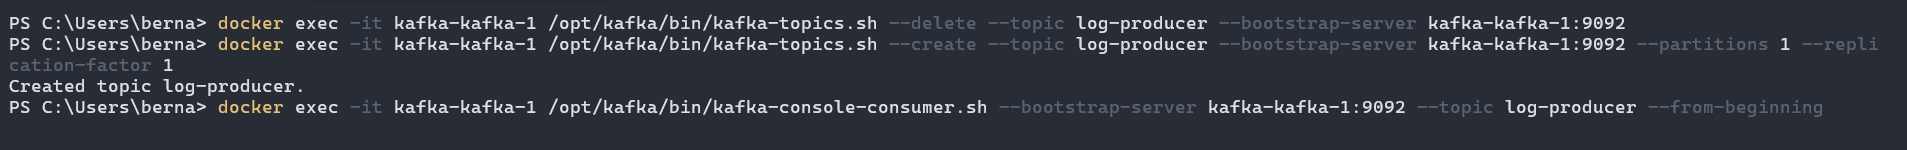

# Crear Spark Session

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Streaming Processing") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c85247d9-a0e0-483e-a8a6-48e38b3d4ed5;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

# Crear Schemas y leer csvs generados en Project Batch Procesing para hacer los joins respectivos de checkins con users y gyms 

In [2]:
from bernardoorozco.spark_utils import SparkUtils
base_path = "/opt/spark/work-dir/lib/bernardoorozco/project"

gyms_schema= SparkUtils.generate_schema([
    ("gym_id", "string"),
    ("name", "string"),
    ("city", "string")
])

users_schema= SparkUtils.generate_schema([
    ("user_id", "string"),
    ("username", "string"),
    ("age", "int"),
    ("membership_type", "string")
])

checkins_schema= SparkUtils.generate_schema([
    ("checkin_id", "string"),
    ("gym_id", "string"),
    ("user_id", "string"),
    ("timestamp", "timestamp"),  
    ("equipment", "string"),
    ("duration_min", "int")
])

gyms_df = spark.read.schema(gyms_schema).option("header", True).csv(f"{base_path}/csvs/gyms.csv")
users_df = spark.read.schema(users_schema).option("header", True).csv(f"{base_path}/csvs/users.csv")

# Data Stream desde topico de kafka log-producer

In [3]:
kafka_df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka-kafka-1:9093") \
    .option("subscribe", "log-producer") \
    .option("startingOffsets", "latest") \
    .load()

kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



# # Transformaciones y acciones 

In [4]:
from pyspark.sql.functions import year, month, day, from_json, col
from pyspark.sql.types import StructField, StringType

# Deserializar

df_parsed = kafka_df.select(
    col("value").cast("STRING").alias("json_value"),
    col("timestamp").alias("kafka_timestamp")
)

df_checkins_stream = df_parsed.select(
    from_json(col("json_value"), checkins_schema).alias("data"),col("kafka_timestamp")
    ).select(
        "data.*",
        col("kafka_timestamp")
    )


print("Schema del DataFrame de Checkins (Streaming):")
df_checkins_stream.printSchema()

Schema del DataFrame de Checkins (Streaming):
root
 |-- checkin_id: string (nullable = true)
 |-- gym_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- equipment: string (nullable = true)
 |-- duration_min: integer (nullable = true)
 |-- kafka_timestamp: timestamp (nullable = true)



In [5]:
from pyspark.sql.functions import lit, current_timestamp, window, count, expr, day, month, hour, dayofweek, year

# Joins
df_joined = df_checkins_stream.join(
    users_df, "user_id","left").join(
    gyms_df, "gym_id","left"
)

# Limpieza y creacion de columna
df_processed = df_joined.withColumn(
    "is_long_session_machine", expr("duration_min >= 20").cast("string")
).withColumn(
    "processing_ts", current_timestamp()
)

df_processed=df_processed.withColumn(
    "year", year(col("timestamp"))
).withColumn(
    "month", month(col("timestamp"))
).withColumn(
    "day_of_week", dayofweek(col("timestamp"))
).withColumn(
    "hour", hour(col("timestamp"))
)

# Persistencia

In [6]:
output_path = "/opt/spark/work-dir/lib/bernardoorozco/project/output_streaming/gym_metrics"
checkpoint_path = "/opt/spark/work-dir/lib/bernardoorozco/project/checkpoints/gym_metrics"

query = df_processed.writeStream \
    .trigger(processingTime="15 seconds") \
    .partitionBy("city") \
    .format("parquet") \
    .option("path", output_path) \
    .option("checkpointLocation", checkpoint_path) \
    .outputMode("append") \
    .start()

print(f"Pipeline iniciado. Escribiendo en: {output_path}")

25/11/22 19:20:07 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


Pipeline iniciado. Escribiendo en: /opt/spark/work-dir/lib/bernardoorozco/project/output_streaming/gym_metrics


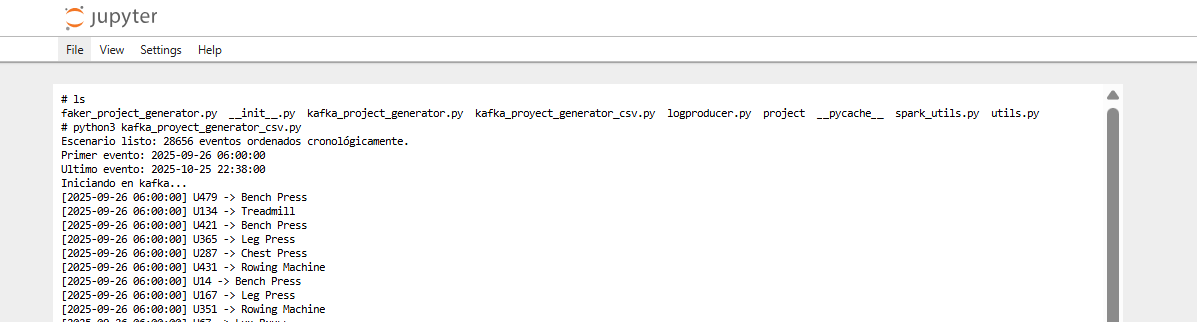
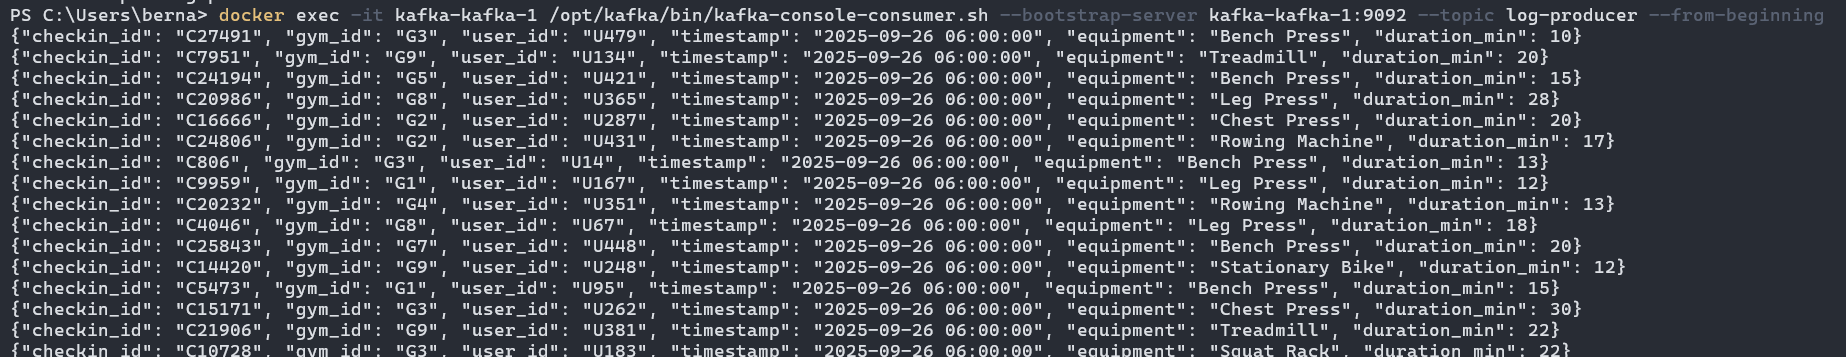
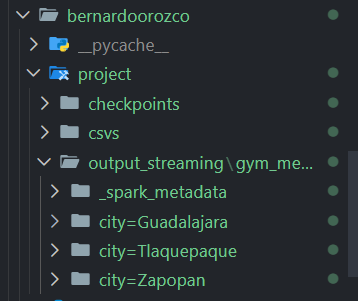

In [9]:
sc.stop()

# Power BI
- Cargamos la carpeta
- Transformamos los datos
- Filtramos por .parquet
- Agregamos columna para extraer city del path de los archivos
- Aceptamos los cambios
- Cargamos los datos de los parquet y la columna de city
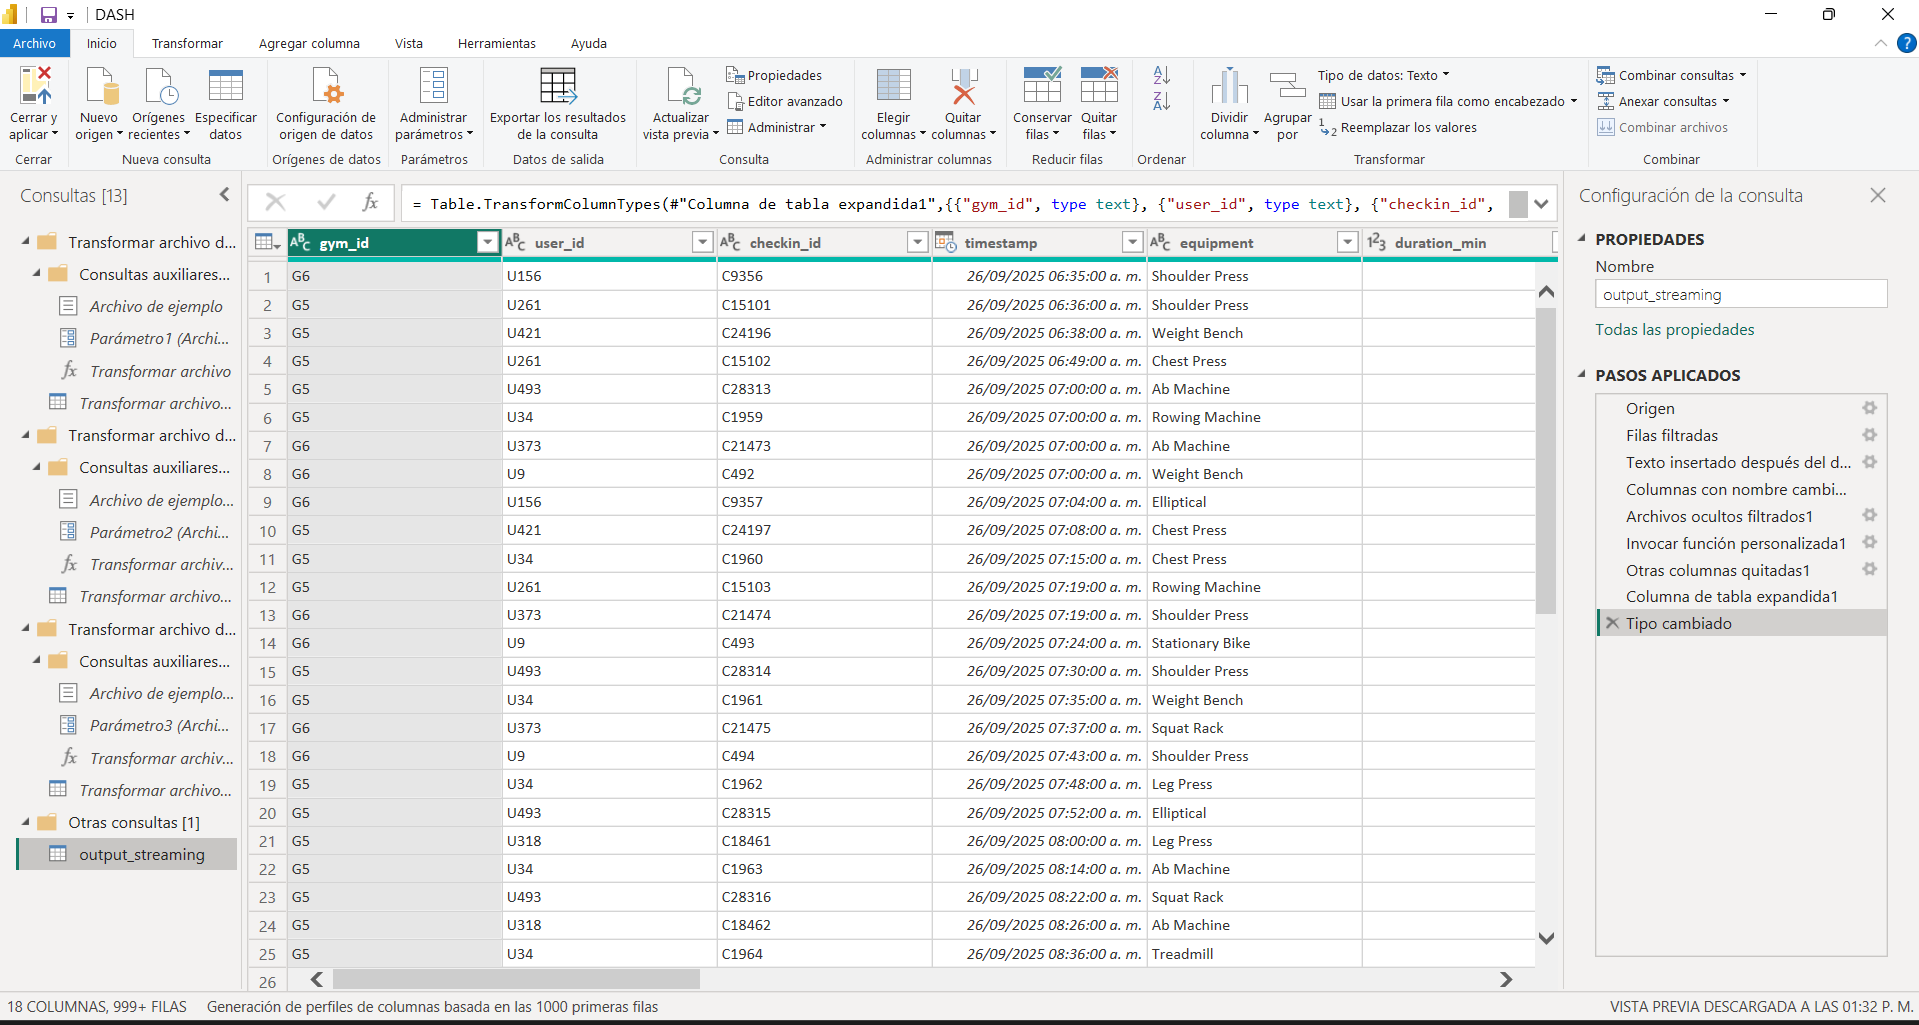

## Dashboards
- Filtros por gym, año, mes, día, hora
- Congestion de ciudades
- Horas con mayor afluencia de checkins
- Ciudades más y gimnasios más congestionados
- Equipos o máquinas mas usadas

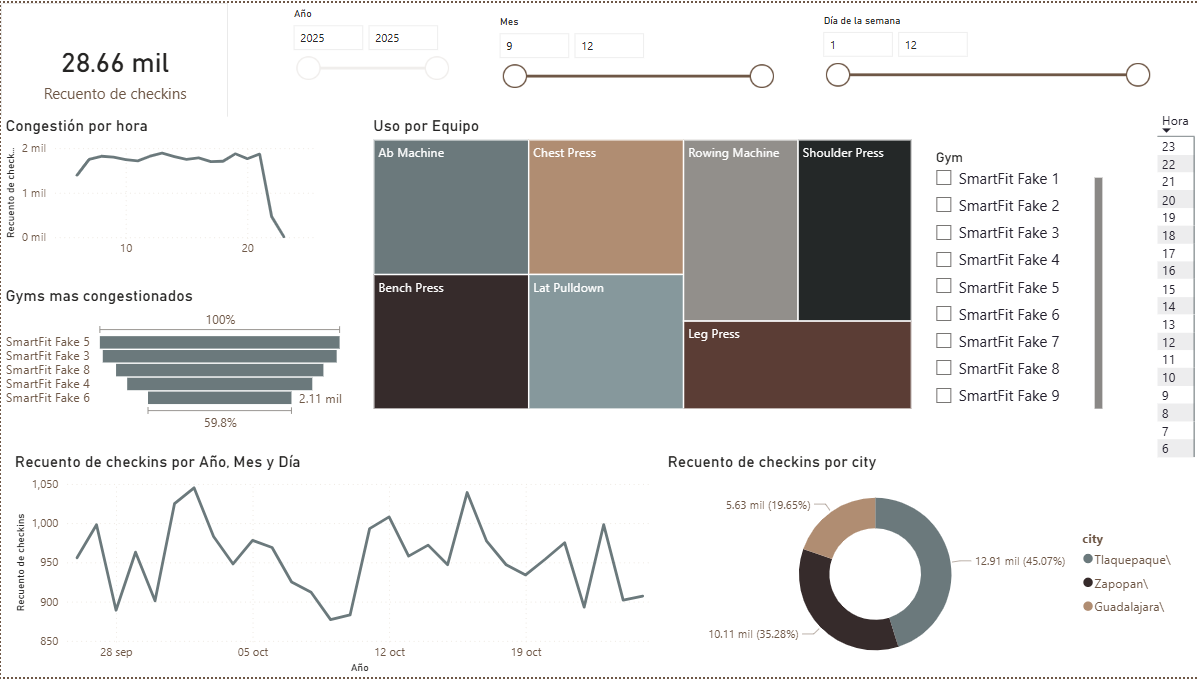